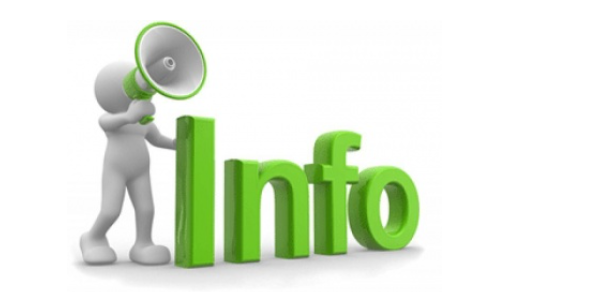

In this programming assignment, you are going to apply clustering algorithms for image compression. Your task is implementing the clustering parts with two algorithms: K-means and K-medoids. It is required you implementing the algorithms yourself rather than calling from a package.



### 1.Input

_pixels_ : the input image representation. Each row contains one data point (pixel). For image dataset, it contains 3 columns, each column corresponding to Red, Green, and Blue component. Each component has an integer value between 0 and 255.
K : the number of desired clusters. Too high value of K may result in empty cluster error. Then, you need to reduce it.
Output

_class_ : cluster assignment of each data point in pixels. The assignment should be 1, 2, 3, etc. For K = 5, for example, each cell of class should be either 1, 2, 3, 4, or 5. The output should be a column vector with size(pixels, 1) elements.
centroid : location of K centroids (or representatives) in your result. With images, each centroid corresponds to the representative color of each cluster. The output should be a matrix with K rows and 3 columns. The range of values should be [0, 255], possibly floating point numbers.
Hand-in


### 2. Instruction 

Both of your code and report will be evaluated. Upload them together as a zip file. In your report, answer to the following questions:

Within the K-medoids framework, you have several choices for detailed implementation. Explain how you designed and implemented details of your K-medoids algorithm, including (but not limited to) how you chose representatives of each cluster, what distance measures you tried and chose one, or when you stopped iteration.
Attach a picture of your own. We recommend size of 320 × 240 or smaller.
Run your K-medoids implementation with the picture you chose above, with several different K. (e.g, small values like 2 or 3, large values like 16 or 32) What did you observe with different K? How long does it take to converge for each K?
Run your K-medoids implementation with different initial centroids/representatives. Does it affect final result? Do you see same or different result for each trial with different initial assignments? (We usually randomize initial location of centroids in general. To answer this question, an intentional poor assignment may be useful.)
Repeat question 2 and 3 with K-means. Do you see significant difference between K-medoids and K-means, in terms of output quality, robustness, or running time?

In [5]:

from matplotlib import pyplot as plt
from PIL import Image
import numpy as np 
import timeit
import sys

In [85]:
class Preprocessing(object):
    def __init__(self,original_arr,modified_arr):
        self.original_arr=original_arr
        self.modified_arr=modified_arr
        
    @classmethod
    def readMessage(cls,path):
        img=Image.open(path)
        img_arr=np.array(img,dtype='int32')
        r,c,I=img_arr.shape
        img_reshaped=np.reshape(img_arr,(r*c,I),order="C")
        return cls(img_arr,img_reshaped)
    
    def displayOriginal(self,h_size=10,v_size=10):
        plt.figure(figsize=(h_size,v_size))
        plt.imshow(self.original_arr)
        
path=r'C:\Users\sd4be\OneDrive\바탕 화면\input\blackpink.jpg'
shapes=Preprocessing.readMessage(path).modified_arr.shape
data=Preprocessing.readMessage(path).modified_arr
Preprocessing.readMessage(path).original_arr.shape
originalData=Preprocessing.readMessage(path).original_arr

In [88]:
from collections import defaultdict
from abc import *
class Cluster(metaclass = ABCMeta):
    def __init__(self,X,k):
        self.X= X
        self.k=k
        self.rowNumber=self.X.shape[0]
        self.col=self.X.shape[1]
        self.originalCost=np.inf
        self.labels=None
        self.cost=np.inf
    
    
      

    def initialCenters(self):
        samples=np.random.choice(self.rowNumber,size=self.k,replace=False)
        return self.X[samples,:]
    
    def assignClusterLabel(self,distMatrix):
        return np.argmin(distMatrix,axis=1)
    
    @abstractmethod
    def computeDist(self,samples):
        pass
    @abstractmethod
    def predict(self):
        pass
    
    
         
class  KMedoids(Cluster):
    def __init__(self,X,k):
        self.X= X
        self.k=k
        self.rowNumber=self.X.shape[0]
        self.col=self.X.shape[1]
        self.originalCost=np.inf
        self.labels=None
        self.cost=np.inf
        self.centers=None
      
    def computeDist(self,samples):
        distanceMatrix=np.abs(self.X[:,None]-samples).sum(-1)
        cost=np.min(distanceMatrix,axis=1).sum()
        return cost,distanceMatrix

    def predict(self,maxIter=1000,eps=0.001):
        convergence=False
        iteration=1
        start_time=timeit.default_timer()
        while (not convergence) and (iteration<=maxIter):
            centers=self.initialCenters()
            cost,distMatrix=self.computeDist(centers)
           
            if cost<self.cost:
                if self.cost!=np.inf:
                    percent_cost=(self.cost-cost)/self.cost
                    if percent_cost<=eps:
                        convergence=True
                self.cost=cost
                self.labels=self.assignClusterLabel(distMatrix)
                self.centers=centers
            iteration+=1
        end_time=timeit.default_timer()
        timetaken=np.round(end_time-start_time,5)
        print("Given the limit for the % in cost-reduction,the K-Medoies for {0} clusters deems to converges in {1} iterations and takes {2} seconds"
             .format(self.k,iteration-1,timetaken))
            
  

        

In [89]:
kmedoids_results=dict()
cluster_numbers=[2,8,20]
for c in cluster_numbers:
    kmedoids=KMedoids(data,c)
    kmedoids.predict()
    cluster='{} clusters'.format(c)
    kmedoids_results[cluster]=(kmedoids.centers,kmedoids.labels)
    
    


Given the limit for the % in cost-reduction,the K-Medoies for 2 clusters deems to converges in 1000 iterations and takes 4.19302 seconds
Given the limit for the % in cost-reduction,the K-Medoies for 8 clusters deems to converges in 1000 iterations and takes 14.57967 seconds
Given the limit for the % in cost-reduction,the K-Medoies for 20 clusters deems to converges in 1000 iterations and takes 35.26349 seconds


In [34]:
class KMean(Cluster):
    def __init__(self,X,k):
        self.X=X
        self.k=k
        self.rowNumber=self.X.shape[0]
        self.colNumber=self.X.shape[1]
        self.labels=None
        self.centers=None
    
    def computeDist(self,centers):
        distMatrix=np.empty((self.rowNumber,self.k))
        for r in range(self.rowNumber):
            d=np.linalg.norm(self.X[r,:]-centers,ord=2,axis=1)
            distMatrix[r,:]=d**2
        return distMatrix

    
    def updateCenters(self,labels):
        assert type(labels)==np.ndarray
        assert self.rowNumber==labels.shape[0]
        updatedCenters=np.empty((self.k,self.colNumber))
        
        for i in range(self.k):
            updatedCenters[i,:self.colNumber]=np.mean(self.X[labels==i,:],axis=0)
        return updatedCenters
    
    def isConvergence(self,originalCenters,updatedCenters):
        return set([tuple(x) for x in originalCenters])==set([tuple(y) for y in updatedCenters])
    
    
    def predict(self,startCetner=None,maxIter=1000):
        if startCetner is None:
            centers=self.initialCenters()
        convergence=False
        labels=np.zeros(self.rowNumber)
        iteration=1
        startTime=timeit.default_timer()
        while (not convergence) and (iteration<=maxIter):
            oldCenters=centers
            distMatrix=self.computeDist(centers)
            labels=self.assignClusterLabel(distMatrix)
            centers=self.updateCenters(labels)
            convergence=self.isConvergence(oldCenters,centers)
            iteration+=1
        terminateTime=timeit.default_timer()
        timediff=round(terminateTime-startTime)
        self.labels=labels
        self.centers=centers
    
        print("Kmean for {0} cluster centers has converged within {1} iterations and taken {2} seconds to fjnish".format(self.k,iteration,\
                                                                                                                         timediff))
        
    


In [81]:
kmean_results=dict()
cluster_numbers=[2,8,20]
for c in cluster_numbers:
    kmean=KMean(data,c)
    kmean.predict()
    cluster='{} clusters'.format(c)
    kmean_results[cluster]=(kmean.centers,kmean.labels)
    
    


Kmean for 2 cluster centers has converged within 11 iterations and taken 6 seconds to fjnish
Kmean for 8 cluster centers has converged within 98 iterations and taken 53 seconds to fjnish
Kmean for 20 cluster centers has converged within 292 iterations and taken 166 seconds to fjnish


In [24]:
def convertImage(centers,labels,originalShapes):
    img_center=np.array([centers[label] for label in labels])
    img_disp=np.reshape(img_center,originalShapes)
    return img_disp    

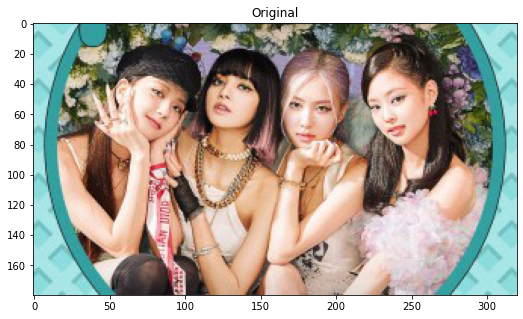

In [75]:
fig,ax=plt.subplots(sharex=True,figsize=(10,5))
images=Image.open(r'C:\Users\sd4be\OneDrive\바탕 화면\input\blackpink.jpg')
image=np.array(images)
ax.set_title("Original")
ax.imshow(image)

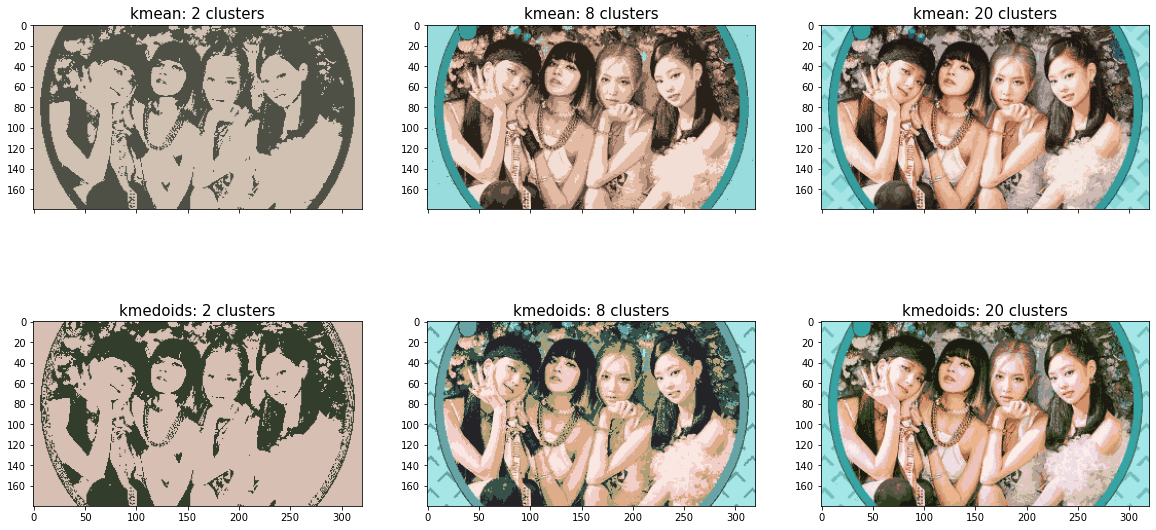

In [99]:
fig,axes=plt.subplots(nrows=2,ncols=3,figsize=(20,10),sharex=True)
title="kmeans"

for row in range(2):
    if row==0:
        result=kmean_results
        title="kmean"
    else:
        result=kmedoids_results
        title="kmedoids"
    for col,cluster in zip(range(3),result):
        values=result[cluster]
        img_disp=convertImage(values[0],values[1],(180,320,3))
        axes[row][col].imshow(img_disp.astype("uint8"))
        axes[row][col].set_title(title+": "+cluster,size=15)

### 3. Conclusion

We have experimented on the performance of each algorithm with various numbers of k-means. The initial cluster centers for both algorithms have been defined by randomly selecting k existing data points.  

There are a couple of points we should be attentive to.



First, K-medoid is well known for its less vulnerability to outliers since the computation is based on the mean value of the object in a cluster that is the most centrally located. But unlike the theoretical point of view, our results do not show much difference in the quality of pictures in comparing one to another. This should be due to the nature of the data we have used in our experiments. Even though depending on the data we have the comparison may seem different, I would place the slight edge on the K-means. The computation time was much higher under the K-means algorithm for all the levels of clusters but K-medoids failed to converge but the intervention was required to stop the iteration if it exceeds the pre-assigned number.

Second, limiting the size of the picture to 320 x 240 as recommended by the instructor helps our algorithm to increase the chance of having a global minimum in the cost, leading to a better outcome than it is. Any algorithm based on the EM algorithm is notorious for failing to have the optimal solution but converging to the local minimum. In both cases, the closed solution to the mean says that the maximum likelihood models we need to iterate over all possible assignments to the clusters. If we had used the original size of the data, there are about an overwhelming number of possible arrangements our local machine should compute, which is not unfeasible to calculate. Instead, reducing its size lowers the possible arrangements, helping algorithms to find the better optimal solution.